# Download Borough Park Street Network

In [66]:
import geopandas as gpd
import numpy as np
import osmnx as ox
import matplotlib.pyplot as plt
%matplotlib inline

In [155]:
def getStreetsByPolygon(polygon, mode, node_color='#66ccff', node_size=30, node_zorder=2, node_edgecolor='k'):
    G = ox.graph_from_polygon(polygon, network_type=mode)
    G = ox.project_graph(G, to_crs={'init': 'epsg:3857'})
    stats_ = ox.basic_stats(G)
    fig, ax = ox.plot_graph(G, show=True, save=False,fig_height=20, node_color=node_color, node_size=node_size, 
                            node_zorder=node_zorder, node_edgecolor=node_edgecolor)
    return G, stats_

In [156]:
borough_park = gpd.read_file('../data/neighborhood_tabulation_areas/top_predictions/borough_park.shp')

In [157]:
borough_park.head()

,NTACode,NTAName,Borough,Year,Population,numStation,geometry
0,BK88,Borough Park,Brooklyn,2010,106357,0,POLYGON ((-73.97604935657381 40.63127590564677...


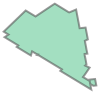

In [158]:
polygon = borough_park.loc[0]['geometry']
polygon

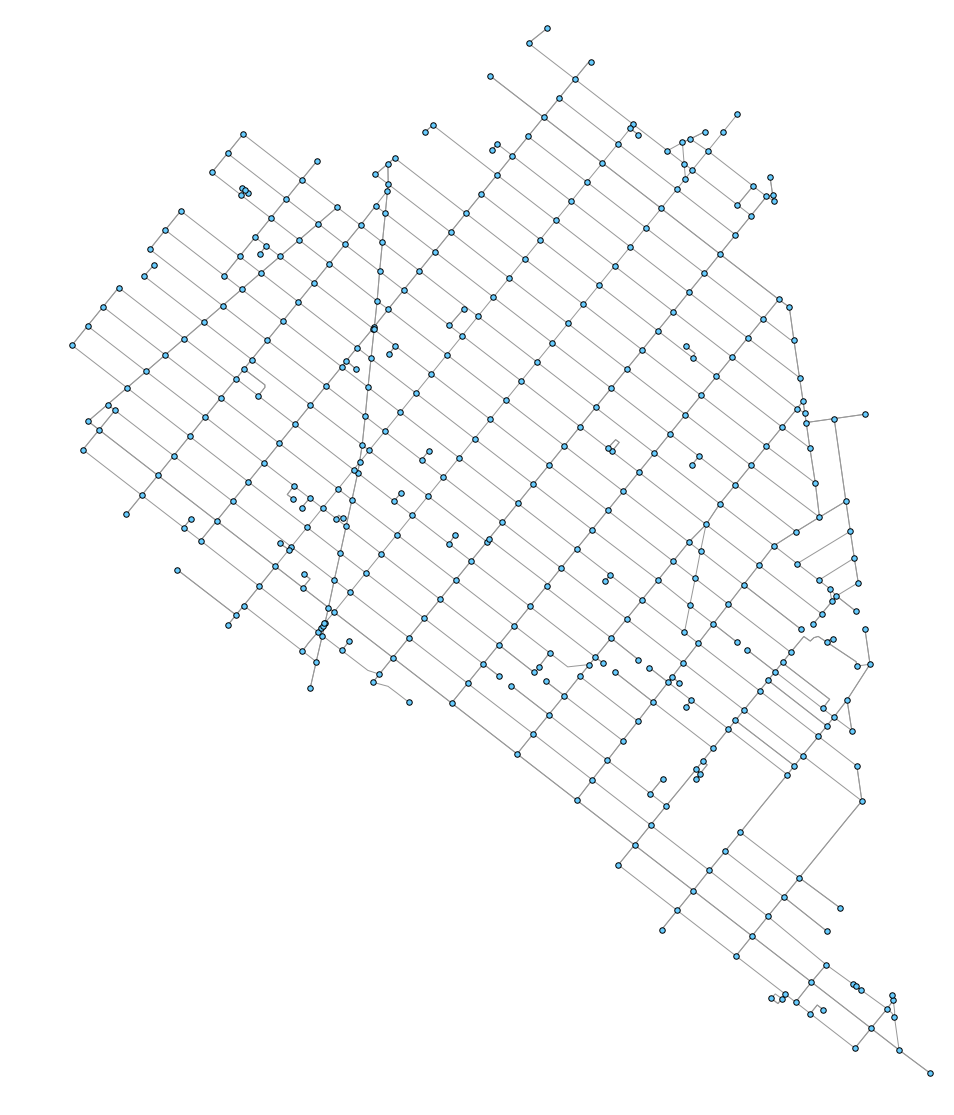

In [159]:
streets, stats = getStreetsByPolygon(polygon, mode='bike');

In [221]:
len(streets.nodes())

425

# Clean up the intersections

Source: https://github.com/gboeing/osmnx-examples/blob/master/notebooks/14-clean-intersection-node-clusters.ipynb

*We'll specify that any nodes with 15 meters of each other in this network are part of the same intersection. Adjust this tolerance based on the street design standards in the community you are examining, and use a projected graph to work in meaningful units like meters. We'll also specify that we do not want dead-ends returned in our list of cleaned intersections. Then we extract their xy coordinates and plot it to show how the clean intersections below compare to 
the topological edge intersections above.*

In [183]:
# clean up the intersections and extract their xy coords
intersections = ox.clean_intersections(streets, tolerance=15, dead_ends=False)
points = np.array([point.xy for point in intersections])

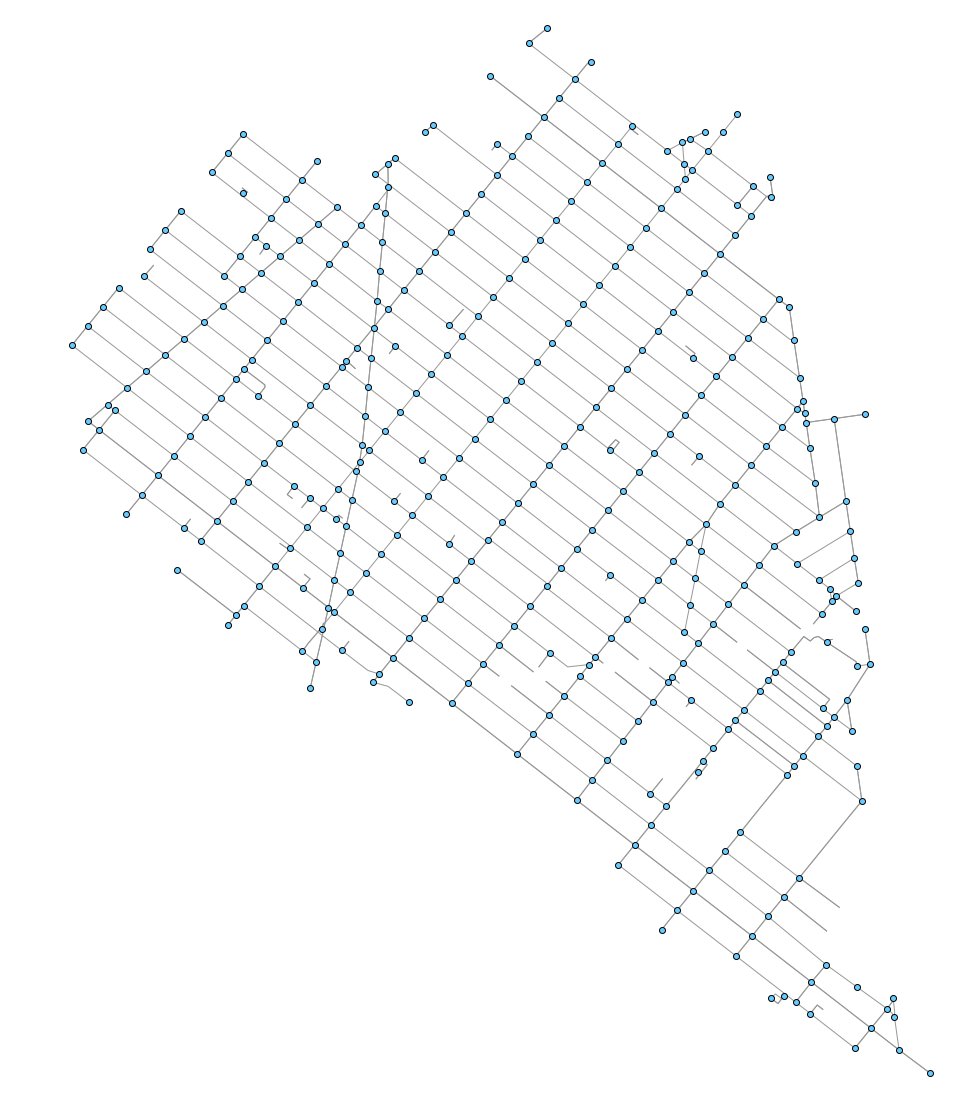

In [184]:
# plot the cleaned-up intersections
fig, ax = ox.plot_graph(streets, fig_height=20, show=False, close=False, node_alpha=0)
ax.scatter(x=points[:,0], y=points[:,1], zorder=2, color='#66ccff', edgecolors='k')
plt.show()

In [222]:
len(intersections)

361

# Reproject nodes to lat-lon

In [225]:
from functools import partial
import pyproj
from shapely.ops import transform
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [226]:
intersections.loc[0:2]

0    POINT (-8234747.733642889 4955578.345774663)
1    POINT (-8234878.478384824 4955678.563065642)
2     POINT (-8235062.712142089 4955686.33530107)
dtype: object

In [227]:
def reproject_nodes(intersections):
    
    lats = []
    lons = []
    
    for i in intersections.index:

        node = intersections.loc[i]

        project = partial(
            pyproj.transform,
            pyproj.Proj(init='epsg:3857'), # source coordinate system
            pyproj.Proj(init='epsg:4326')) # destination coordinate system

        node_projected = transform(project, node)  # apply projection
        lon = list(node_projected.coords)[0][0]
        lat = list(node_projected.coords)[0][1]
        lats.append(lat)
        lons.append(lon)
    
    df = gpd.GeoDataFrame()
    df['latitude'] = lats
    df['longitude'] = lons    
    geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
    crs = {'init': 'epsg:4326'}
    gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    
    return gdf

In [228]:
output = reproject_nodes(intersections)

In [229]:
len(output)

361

In [230]:
output.head()

,latitude,longitude,geometry
0,40.614041,-73.973997,POINT (-73.97399749999997 40.61404059999997)
1,40.614724,-73.975172,POINT (-73.97517199999994 40.61472399999997)
2,40.614777,-73.976827,POINT (-73.97682699999997 40.61477699999998)
3,40.615359,-73.976223,POINT (-73.97622299999998 40.61535899999998)
4,40.615679,-73.975344,POINT (-73.97534389999996 40.61567929999998)


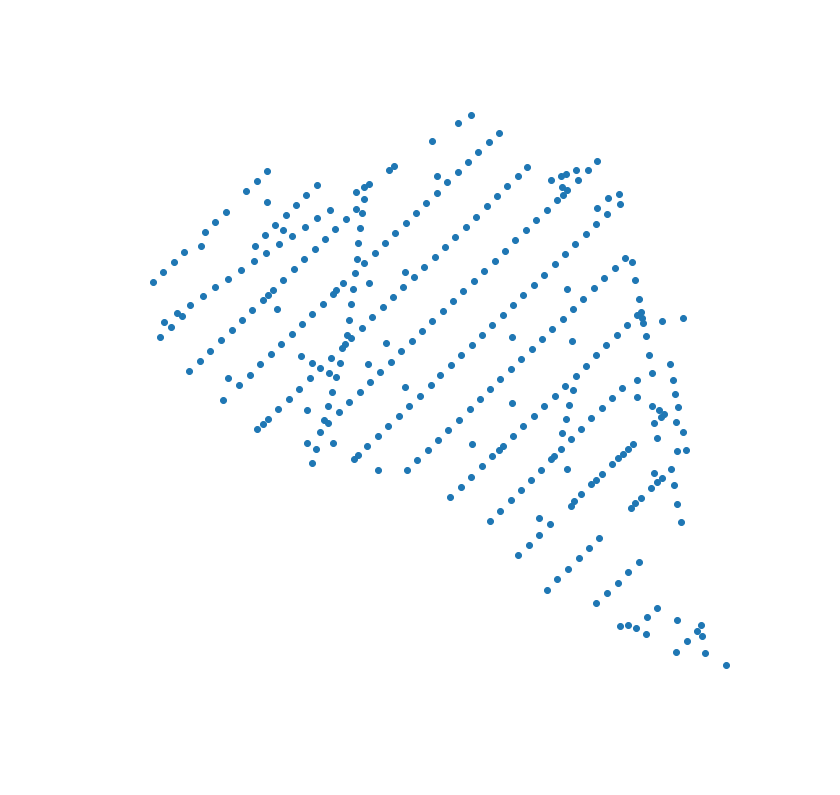

In [231]:
f, ax = plt.subplots(figsize=(14,14))
ax.set_axis_off()
output.plot(ax=ax)

In [ ]:
output.to